In [128]:
%%pyspark
df = spark.read.load('abfss://files@tranghuyen.dfs.core.windows.net/sales_data/OnelineRetail.csv', format='csv'
, header=True
)
display(df.limit(10))

StatementMeta(sparkpool, 7, 129, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 11ebdd65-fb32-4e8c-ae25-499b956ef2b5)

In [130]:
# Đếm xem có bao nhiêu dòng dữ liệu
df.count()

StatementMeta(sparkpool, 7, 131, Finished, Available, Finished)

532621

In [131]:
# Có bao nhiêu khách hàng
df.select('CustomerID').distinct().count()

StatementMeta(sparkpool, 7, 132, Finished, Available, Finished)

4340

In [132]:
from pyspark.sql.functions import countDistinct, desc

# Quốc gia nào có số lượng khách hàng thế nào
df.groupBy('Country') \
  .agg(countDistinct('CustomerID').alias('country_count')) \
  .orderBy(desc('country_count')) \
  .show()

StatementMeta(sparkpool, 7, 133, Finished, Available, Finished)

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3921|
|        Germany|           94|
|         France|           87|
|          Spain|           30|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           14|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|        Denmark|            9|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|         Sweden|            8|
|         Cyprus|            8|
|          Japan|            8|
|         Poland|            6|
|         Greece|            4|
+---------------+-------------+
only showing top 20 rows



In [133]:
from pyspark.sql.functions import to_timestamp
# Định dạng lại trường dữ liệu ngày tháng thành timestamp để có thể sort, tìm min hoặc max
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn('date',to_timestamp("InvoiceDate", 'yy-MM-dd HH:mm:ss'))

StatementMeta(sparkpool, 7, 134, Finished, Available, Finished)

In [134]:
from pyspark.sql.functions import max
# Ngày có đơn hàng gần đây nhất
df.select(max("date")).show()

StatementMeta(sparkpool, 7, 135, Finished, Available, Finished)

+-------------------+
|          max(date)|
+-------------------+
|2011-12-09 12:50:00|
+-------------------+



In [135]:
from pyspark.sql.functions import min
# Ngày đầu tiên có đơn hàng
df.select(min("date")).show()

StatementMeta(sparkpool, 7, 136, Finished, Available, Finished)

+-------------------+
|          min(date)|
+-------------------+
|2010-12-01 08:26:00|
+-------------------+



Tạo 1 cột mới, đặt giá trị của tất cả cột đó là ngày đầu tiên có đơn hàng. Cột này có tên "from_date"

In [136]:
from pyspark.sql.functions import lit
df = df.withColumn("from_date", lit("2010-12-01 08:26:00")) 

StatementMeta(sparkpool, 7, 137, Finished, Available, Finished)

In [137]:
display(df)

StatementMeta(sparkpool, 7, 138, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 63b111e8-961d-4dbc-bede-1397d90abba5)

Lấy thời gian mua của từng đơn hàng trừ đi from_date

In [138]:
from pyspark.sql.functions import col
df = df.withColumn('from_date',to_timestamp("from_date", 'yy-MM-dd HH:mm'))
df2 = df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))

StatementMeta(sparkpool, 7, 139, Finished, Available, Finished)

In [139]:
display(df2)

StatementMeta(sparkpool, 7, 140, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 0942844e-fb8e-4919-ac6e-2b300be374c9)

Mỗi khách hàng có thể mua nhiều lần vào nhiều mốc thời gian khác nhau, chúng ta chỉ quan tâm lần cuối cùng họ mua, vì vậy cần xử lý lại cột 'recency'

In [140]:
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')
display(df2)

StatementMeta(sparkpool, 7, 141, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 37f30fd4-068c-44da-b0ee-14b950bedf3d)

Frequency
Phần này thì chúng ta sẽ tính tần suất một khách hàng mua một đồ gì đó. Chúng ta chỉ cần nhóm theo từng ID khách hàng và đếm số mặt hàng họ đã mua

In [141]:
from pyspark.sql.functions import aggregate
from pyspark.sql.functions import count
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceNo').alias('frequency'))
display(df_freq)

StatementMeta(sparkpool, 7, 142, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, ac101294-c3aa-4c16-8458-c1a191958b37)

Nối nó vào dataframe 

In [142]:
df3 = df2.join(df_freq,on='CustomerID',how='inner')

StatementMeta(sparkpool, 7, 143, Finished, Available, Finished)

Monetary
Phần này tính xem mỗi khách hàng đã chi bao nhiêu tiền để mua sắm, phần này sẽ chia làm 2 bước

In [143]:
# Tính số tổng tiền của một lần mua hàng.
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))
display(m_val)

StatementMeta(sparkpool, 7, 144, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 46636211-d14b-43bc-8cc0-b752c24d25ac)

In [144]:
from pyspark.sql.functions import  sum
# Tính tổng số tiền mà khách hàng đã chi
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))

StatementMeta(sparkpool, 7, 145, Finished, Available, Finished)

In [145]:
display(m_val)

StatementMeta(sparkpool, 7, 146, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, d132cb26-a478-49ba-a48d-170b5eb8bd23)

Gộp dữ liệu vào dataFrame

In [146]:
final_df = m_val.join(df3,on='CustomerID',how='inner')

StatementMeta(sparkpool, 7, 147, Finished, Available, Finished)

In [147]:
display(final_df)

StatementMeta(sparkpool, 7, 148, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 97fabff5-3dfa-4f4f-9b02-1073f43579e7)

Lấy 4 trường trong dữ liệu đã tính toán trên để xây dựng model dự đoán

In [148]:
final_df = final_df.select(['recency','frequency','monetary_value','CustomerID']).distinct()

StatementMeta(sparkpool, 7, 149, Finished, Available, Finished)

In [149]:
display(final_df)

StatementMeta(sparkpool, 7, 150, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 185607c7-1c91-4395-b9be-af10c60ba561)

Chuẩn hóa dữ liệu

In [150]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(final_df)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)


StatementMeta(sparkpool, 7, 151, Finished, Available, Finished)

In [121]:
data_scale_output.select('standardized').show(2, truncate=False)

StatementMeta(sparkpool, 7, 122, Finished, Available, Finished)

+---------------------------------------------------------------+
|standardized                                                   |
+---------------------------------------------------------------+
|[0.5600258964872281,1.8173891485441498,0.09947228534979743]    |
|[0.011178534170522385,0.02524151595200208,0.037898962130115836]|
+---------------------------------------------------------------+
only showing top 2 rows



TRIỂN KHAI HỌC MÁY

chọn số tâm cụm: Chạy K-means với nhiều cụm và trực quan hóa kết quả, tìm ra điểm uốn giống như khủy tay và lựa chọn điểm này

In [151]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost


StatementMeta(sparkpool, 7, 152, Finished, Available, Finished)

StatementMeta(sparkpool, 7, 153, Finished, Available, Finished)

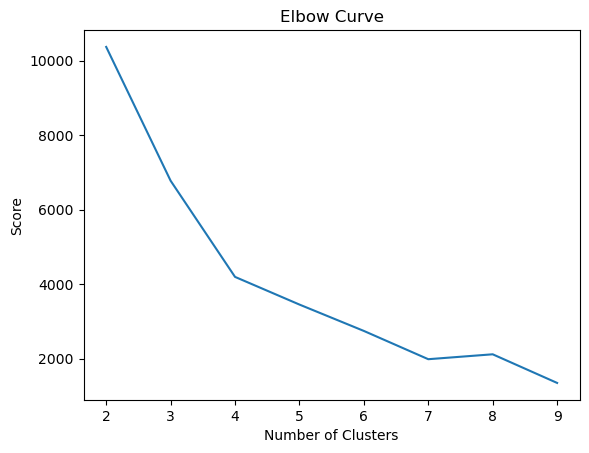

In [152]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()


Triển khai với k=4

In [153]:
#train 
kmeans_algo=KMeans(featuresCol='standardized', k=4)
kmeans_fit=kmeans_algo.fit(data_scale_output)


StatementMeta(sparkpool, 7, 154, Finished, Available, Finished)

Dự đoán

In [154]:
preds=kmeans_fit.transform(data_scale_output)
preds.show(5)

StatementMeta(sparkpool, 7, 155, Finished, Available, Finished)

+-------+---------+------------------+----------+--------------------+--------------------+----------+
|recency|frequency|    monetary_value|CustomerID|            features|        standardized|prediction|
+-------+---------+------------------+----------+--------------------+--------------------+----------+
|4860540|       72|            278.74|   17786.0|[4860540.0,72.0,2...|[0.56002589648722...|         1|
|  97020|        1|             106.2|   15070.0| [97020.0,1.0,106.2]|[0.01117853417052...|         1|
|3549600|        8|             153.9|   16351.0|[3549600.0,8.0,15...|[0.40898087911447...|         1|
|3739860|       20|386.04999999999995|   18085.0|[3739860.0,20.0,3...|[0.43090242015017...|         1|
| 362220|       45| 623.7500000000002|   16718.0|[362220.0,45.0,62...|[0.04173457686298...|         1|
+-------+---------+------------------+----------+--------------------+--------------------+----------+
only showing top 5 rows



sử dụng matplotlib để trực quan hóa phân khúc khách hàng

StatementMeta(sparkpool, 7, 128, Finished, Available, Finished)

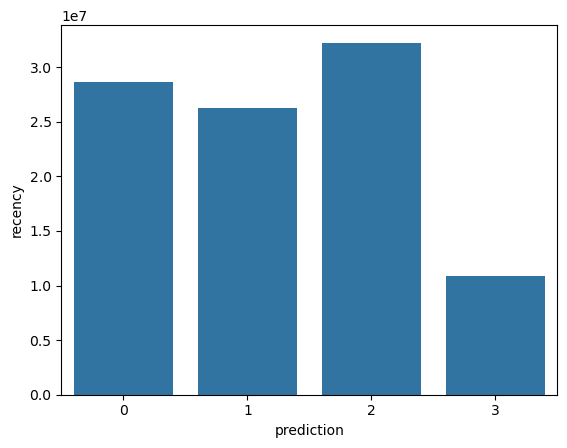

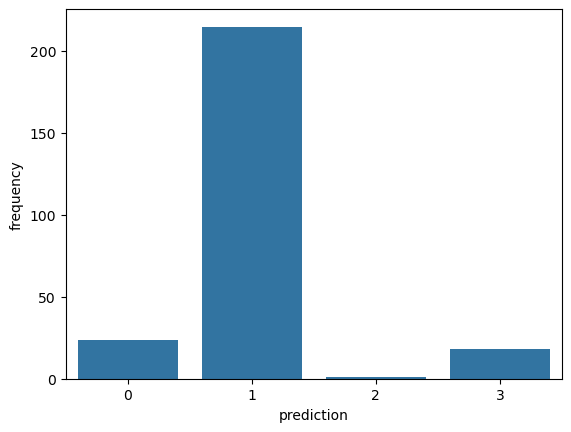

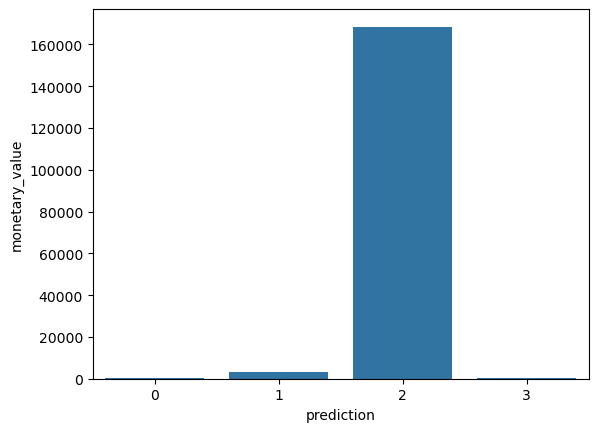

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()
